In [1]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from astropy.table import Table, Column
from scipy import optimize
import math

In [2]:
asciiLC = 'supernova1b_template.dat'
filterNames = ['u', 'g', 'r', 'i', 'z']
colors = {'u':'purple','g':'g','r':'r','i':'blue','z':'m'}
location_of_peak = np.arange(59700, 60000, 30)
height_of_peak = np.arange(17,21,1)

In [3]:
# Set the database and query
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')

# Set the output directory
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [4]:
# The pass metric just passes data straight through.
#choose database and restrictions (such as list of ra and dec)
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,20), np.random.uniform(-60,-30,20))
#slicer = slicers.UserPointsSlicer(0, -45)
#no restrictions currently
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                        outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
def createdict_for_mjd_filter_depth(bundle):
    
    """This function returns a list of tables of exposure day, filter, 
    and five sigma depth for each ra and dec chosen"""
    
    listofDict = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for 
                 key in ['fieldRA', 'fieldDec', 'expMJD', 'filter', 'fiveSigmaDepth']}
        t = Table(bdict)
        t.rename_column('expMJD', 'day')
        t = t[t['filter'] != 'y']
        t.sort('day')
        listofDict.append(t)
    return listofDict

In [6]:
def read_lightcurve(asciifile, f):
    skip = 0
    if f == 'u':
        columns = (0,1,2)
        skip = 40
    elif f == 'g':
        columns = (3,4,5)
    elif f == 'r':
        columns = (6,7,8)
    elif f == 'i':
        columns = (9,10,11)
    elif f == 'z':
        columns = (12,13,14)
    else:
        pass
    #Reads asciifile - three columns (phase, magnitude, filter)
    lc = np.genfromtxt(asciifile, dtype=[('day', np.float), ('mag', np.float), ('error', np.float)],
                       skip_header = 1, skip_footer = skip, usecols = columns)

    return {f:lc}

In [7]:
def add_data_to_lc_table(asciiLC, template):
    '''This function returns a table with phase, magnitude, and filter for a light curve read
    in from an ascii file'''
    for f in filterNames:  
        curvedata = read_lightcurve(asciiLC, f)
        bdict = {key: curvedata[f][key] for key in ['day', 'mag', 'error']}
        t = Table(bdict)
        t['filter'] = f
        for row in range(len(t)):
            t['mag'][row] = -2.5*math.log10(t['mag'][row])
            template.add_row(t[row])
    template.sort('day')
    return template

In [8]:
def normalize_template(template):
    peaktable = peak_brightness(template)
    peakmag = peaktable['g'][1]
    template['mag'] -= peakmag
    return template

In [9]:
def peak_brightness(template):
    
    """This function returns a table of peak magnitude and the day it occurs 
    for each filter from the read in lightcurve"""
    
    peak_brightness = {}
    for f in filterNames:
        fMatch = np.where(template['filter'] == f)
        maxmag = np.amin(template['mag'][fMatch])
        location = np.argmin(template['mag'][fMatch])
        maxday = template['day'][fMatch][location]
        peak_brightness[f] = [maxday, maxmag]
    
    peak = Table(peak_brightness)
    peak[' '] = ['day', 'mag']
    orderedPeak = peak[' ','u','g','r','i','z']
    return orderedPeak

In [10]:
def adjust_peak(template, peakday, peakmag):
    adjusted_template = template.copy()
    """This function finds the necessary adjustment needed to make the peak 
    of the red filter occur at the right place and adjusts all filters by that same ammount"""
    
    adjusted_template['day'] += peakday
    adjusted_template['mag'] += peakmag
    
    return adjusted_template

In [11]:
def adjust_opsim_table(opsim, adjusted_template):
    new_opsim = opsim.copy()
    new_opsim = new_opsim[new_opsim['day']< adjusted_template['day'].max()]
    new_opsim = new_opsim[new_opsim['day']> adjusted_template['day'].min()]
    return new_opsim

In [12]:
def interpolate_light_curve(adjusted_template, new_opsim):
    
    #for each filter interpolate the read in light curve to the days of the opsim in all filters
    
    lc = {}
    for f in filterNames:
        fMatch = np.where(adjusted_template['filter'] == f)
        lc[f] = np.interp(new_opsim['day'], adjusted_template['day'][fMatch], adjusted_template['mag'][fMatch])
    lightcurve = Table(lc)
    lightcurve['day'] = new_opsim['day']
    lightcurve = lightcurve['day', 'u', 'g', 'r', 'i', 'z']
    return lightcurve

In [13]:
def resample_light_curve(lightcurve, new_opsim):
    
    """add to the opsim table a magnitude column where the magnitude is taken 
    from the index of the interpolated light curve where both the filter and day matched the opsim"""
    
    new_opsim['magnitude'] = 0.
    for row in range(len(new_opsim)):
        filterName = new_opsim['filter'][row]
        new_opsim['magnitude'][row] = lightcurve[filterName][row]
    return new_opsim

In [14]:
def calculate_error(new_opsim):
    
    #Calculate the error of the magnitude at each point from the magnitude and fiveSigmaDepth stored in opsim
    
    snr = 5.*10.**(-0.4*(new_opsim['magnitude'] - new_opsim['fiveSigmaDepth']))
    lc_err = 2.5/(np.log(10)*snr)
    new_opsim['error'] = lc_err
    
    return new_opsim

In [15]:
def magnitude_distribution(new_opsim):
    new_opsim['magnitude'] = np.random.normal(new_opsim['magnitude'], new_opsim['error'])
    return new_opsim

In [16]:
def func_per_filter(f):
    def func(time, peak_mag, peak_time):
        new_template = template.copy()
        new_template['mag'] += peak_mag
        new_template['day'] += peak_time
        fMatch = np.where(new_template['filter'] == f)
        model = np.interp(time, new_template['day'][fMatch], new_template['mag'][fMatch], 
                          left=99, right=99)
        return model
    return func

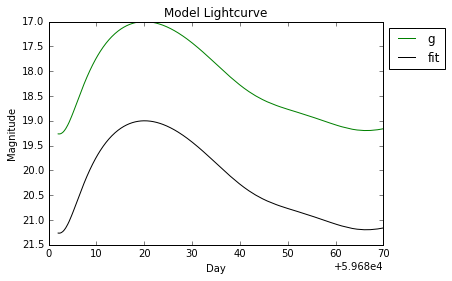

In [57]:
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
template = normalize_template(template)
peakday = 59700
peakmag = 17
adjusted_template = adjust_peak(template, peakday, peakmag)

model_per_filter = func_per_filter('g')
f = 'g'
filter_match = np.where(adjusted_template['filter'] == f)
plt.errorbar(adjusted_template['day'][filter_match], adjusted_template['mag'][filter_match], 
             color=colors[f], label = f)
plt.errorbar(adjusted_template['day'][filter_match], model_per_filter(adjusted_template['day'][filter_match], 19, 59700), 
             color='black', label = 'fit')
plt.ylim(plt.ylim()[::-1])
plt.title('Model Lightcurve')
plt.xlabel('Day')
plt.ylabel('Magnitude')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))


In [17]:
def fit_curve(opsim_fmatch2, template_fmatch2, f):
    xdata = np.arange(template_fmatch2['day'].min(), template_fmatch2['day'].max(), 1)
    initial_parameters = [opsim_fmatch2['magnitude'].min(), 
                          opsim_fmatch2['day'][opsim_fmatch2['magnitude'].argmin()]]
    popt, pcov = optimize.curve_fit(func_per_filter(f), opsim_fmatch2['magnitude'], opsim_fmatch2['day'], 
                                    p0 = initial_parameters, sigma = opsim_fmatch2['error'])
    #print(popt, initial_parameters)
    return (xdata, popt)

In [18]:
def create_curve(f, ra, dec, peakday, peakmag, opsim_fmatch2, template_fmatch2, xdata, popt):
    plt.plot(xdata, func_per_filter(f)(xdata, *popt), 'black' , label='fit')
    #plt.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
    #           yerr = opsim_fmatch2['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(template_fmatch2['day'], template_fmatch2['mag'], 
                     color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(22,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r'
              %(round(ra,3), round(dec,3), peakday, peakmag))
    plt.show()

In [19]:
def resampled_peak_magnitude(ra, dec, f, template_fmatch2, xdata, popt):
    
    peak_magnitude_difference = template_fmatch2['mag'].min() - func_per_filter(f)(xdata, *popt).min()
    
    return [ra, dec, f, peak_magnitude_difference]

In [20]:
def resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt):

    actual_peak_day = template_fmatch2['day'][template_fmatch2['mag'].argmin()]
    fitted_peak_day = func_per_filter(f)(xdata, *popt).argmin() + xdata.min()
    peak_day_difference = actual_peak_day - fitted_peak_day
    
    return [ra, dec, f, peak_day_difference]

In [21]:
def create_peak_difference_table(peak):

    peak_difference = Table(names=('ra', 'dec', 'filter', peak), 
                                dtype=('float', 'float', 'string', 'float'))
    return peak_difference

In [22]:
survey = createdict_for_mjd_filter_depth(bundle)

/home/hbowden/lsst4/Linux64/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


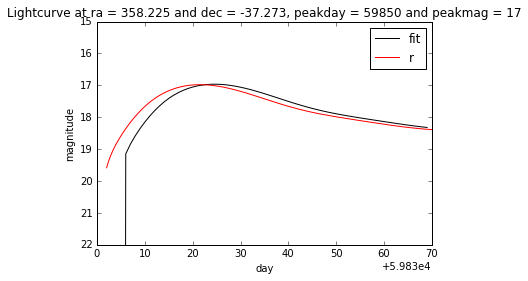

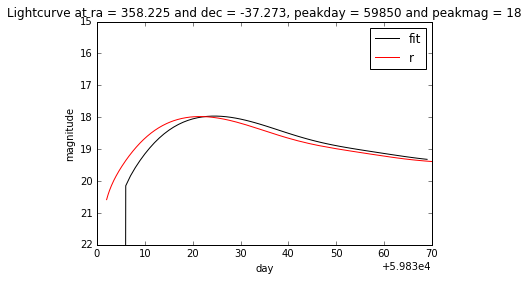

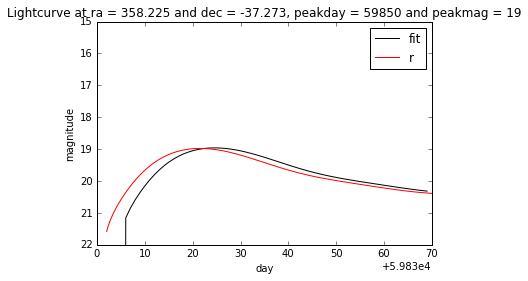

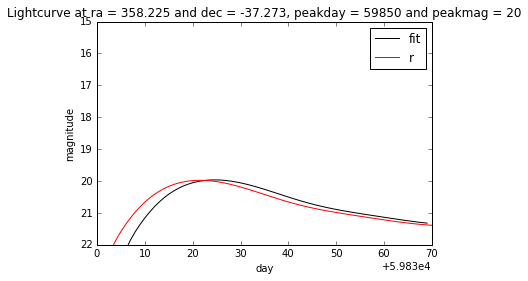

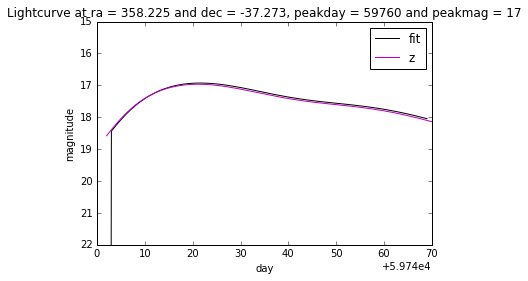

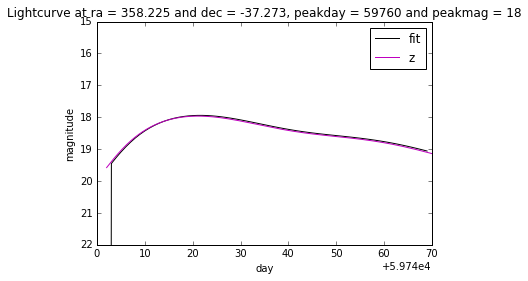

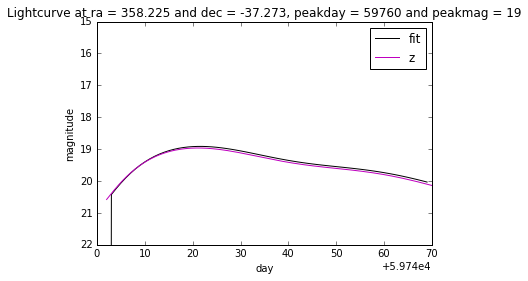

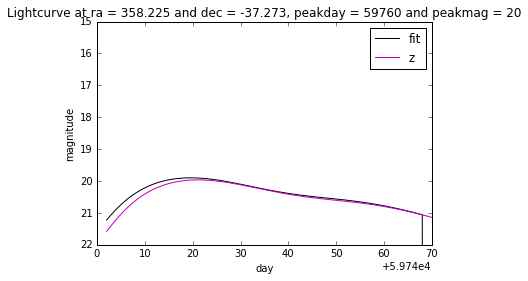

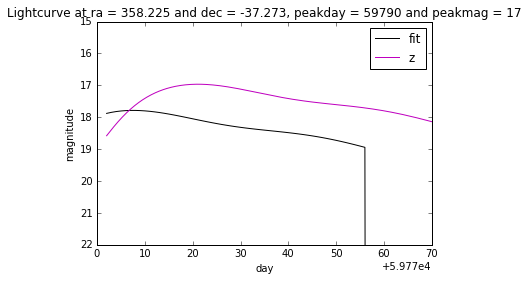

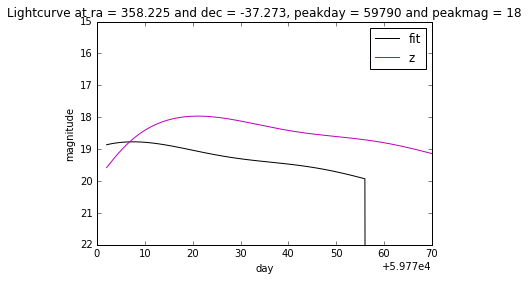

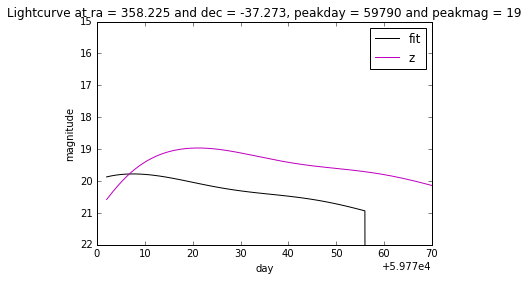

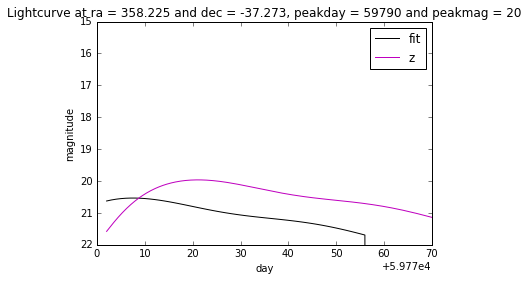

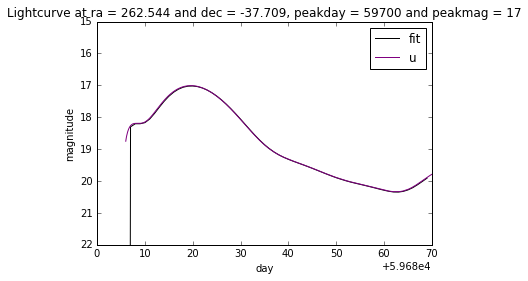

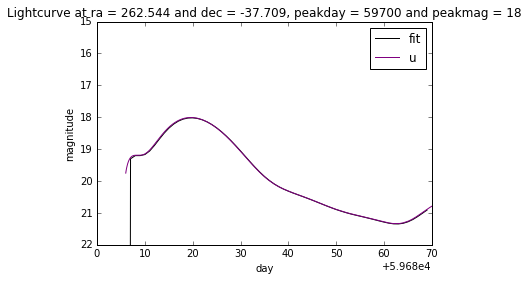

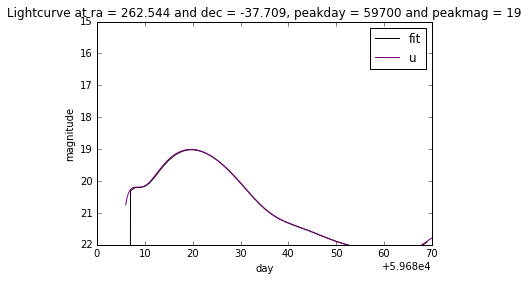

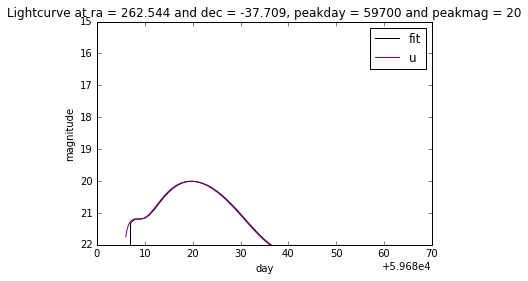

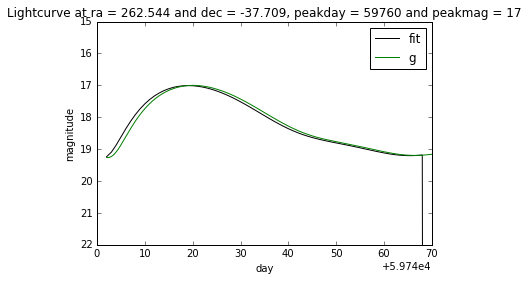

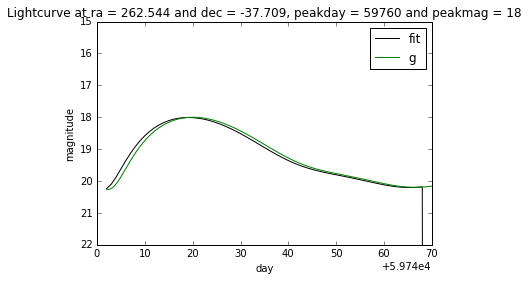

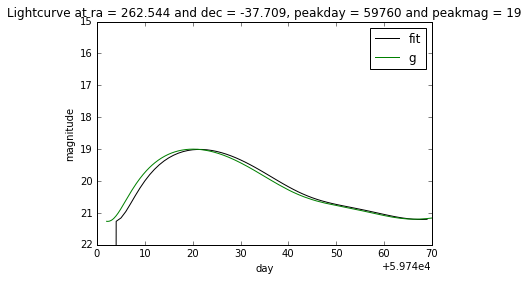

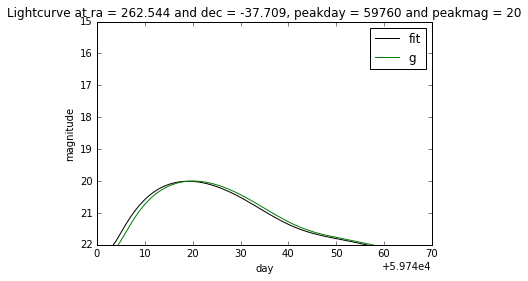

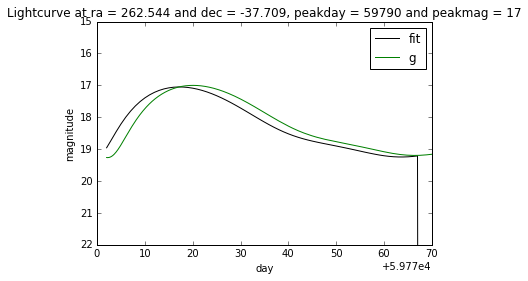

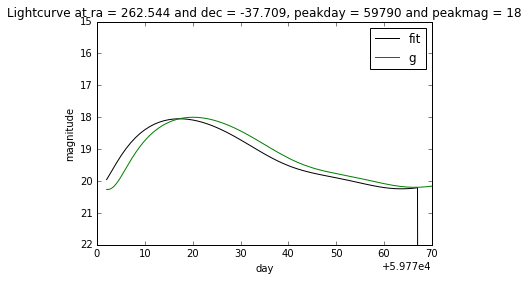

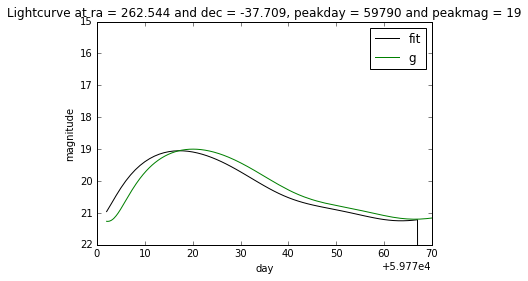

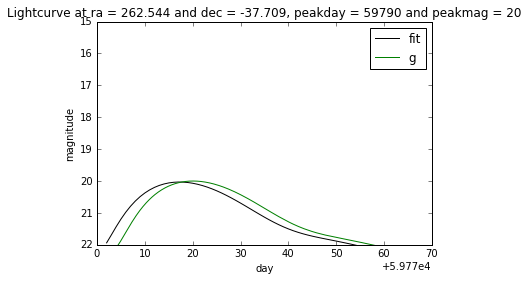

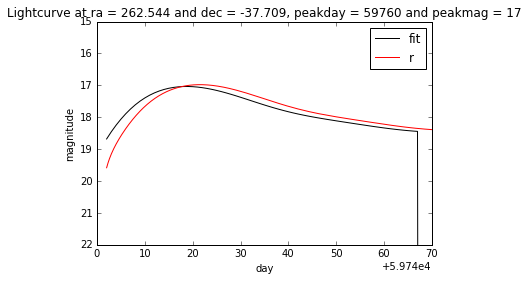

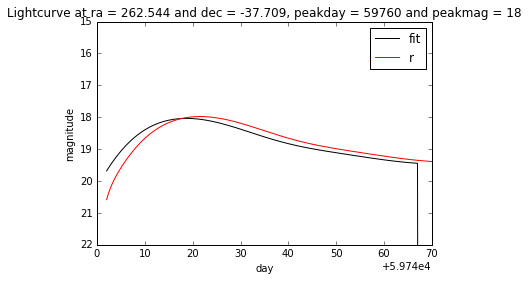

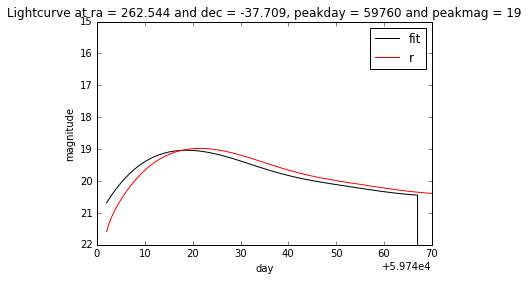

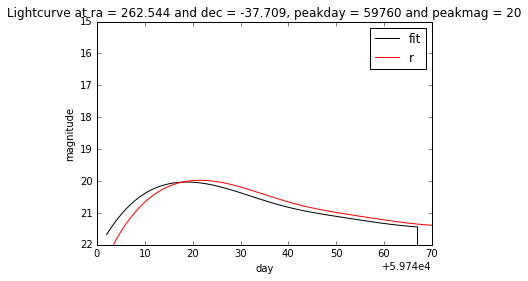

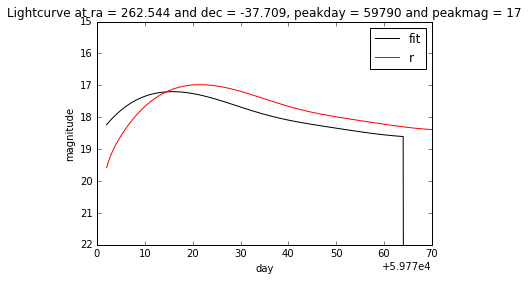

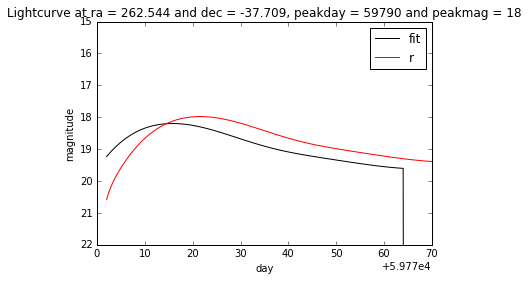

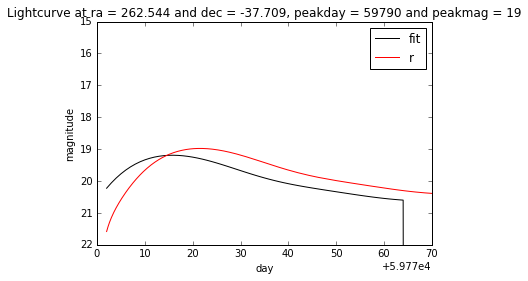

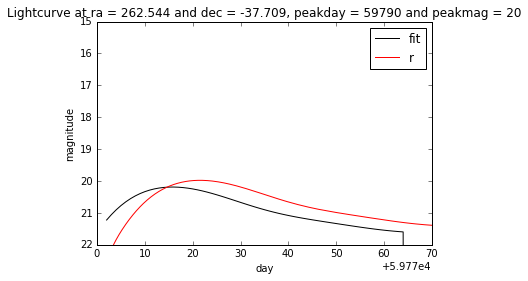

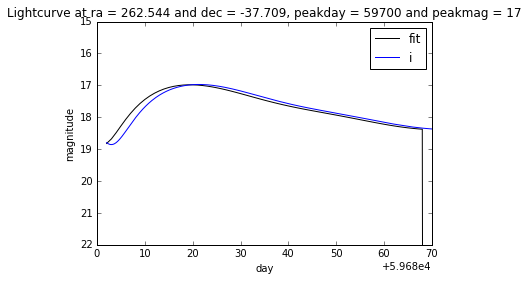

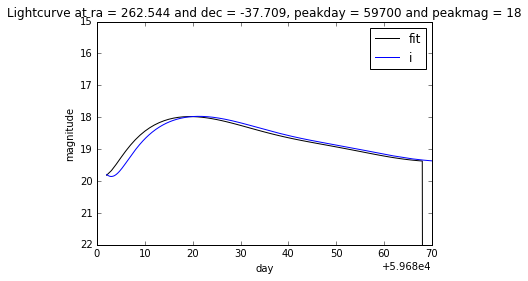

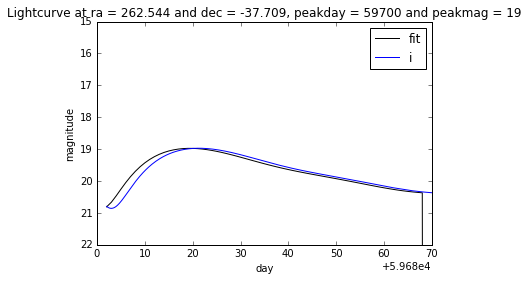

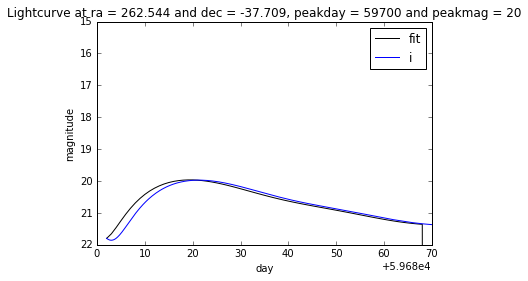

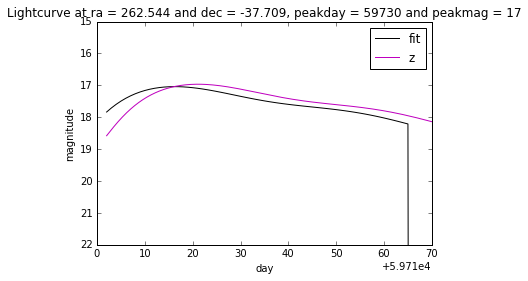

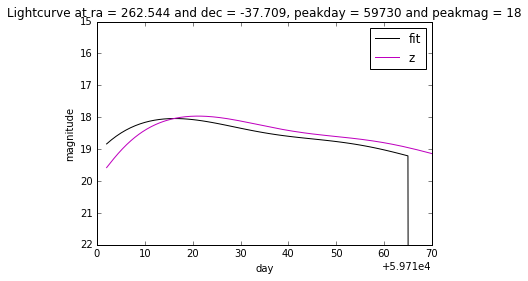

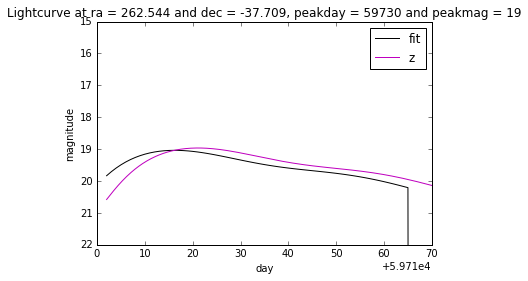

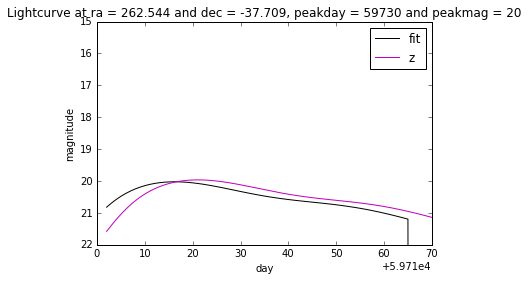

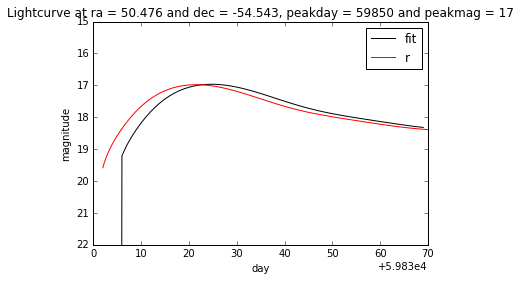

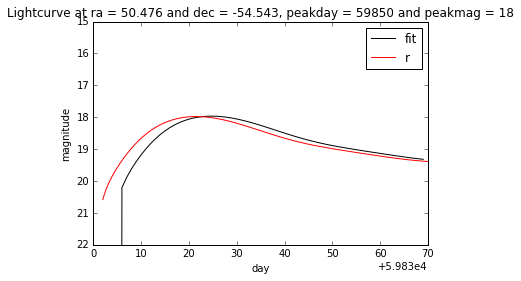

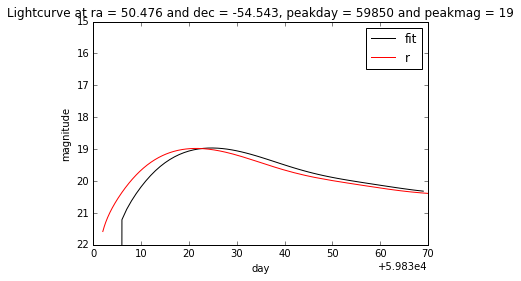

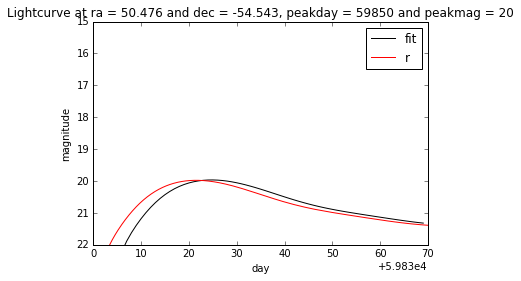

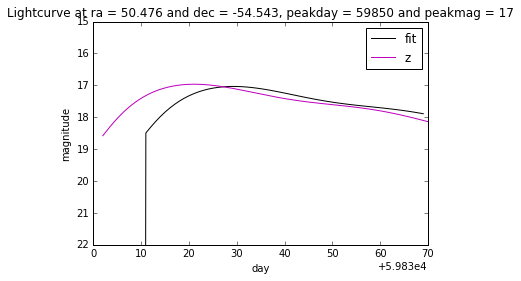

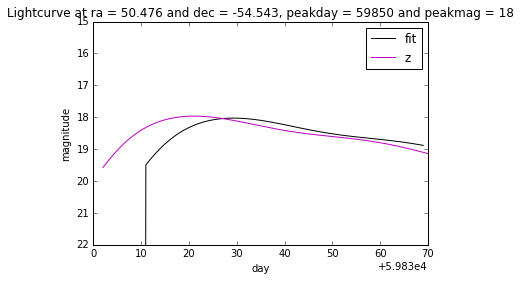

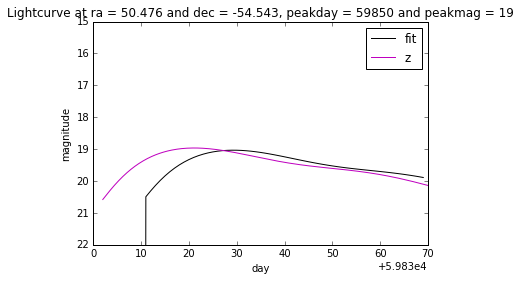

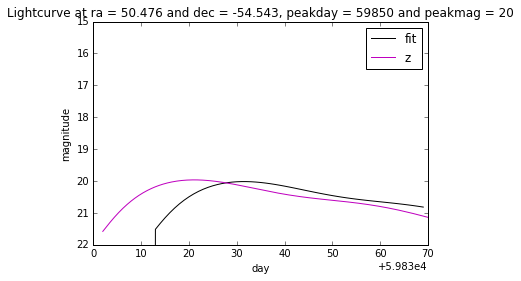

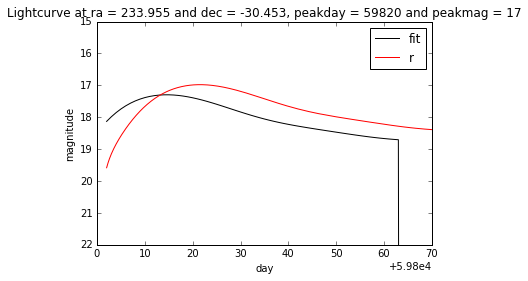

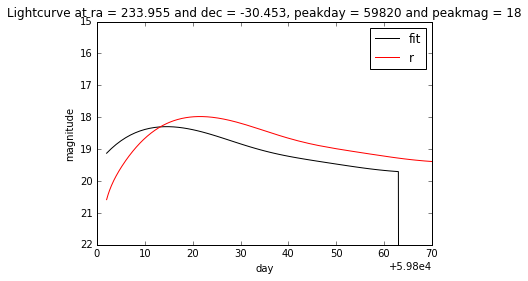

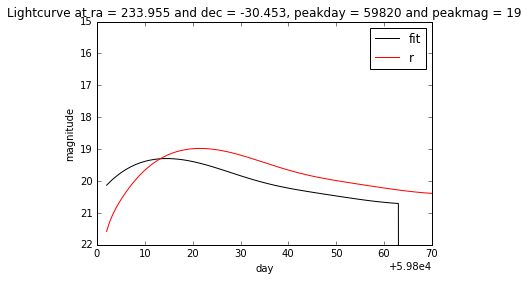

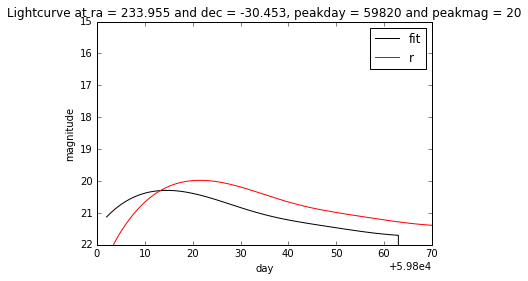

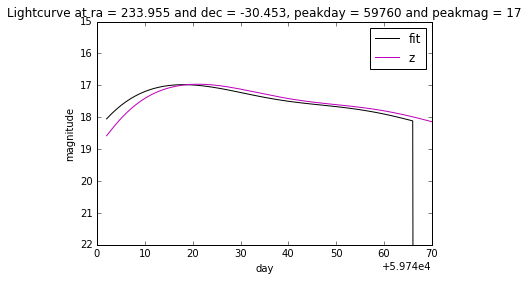

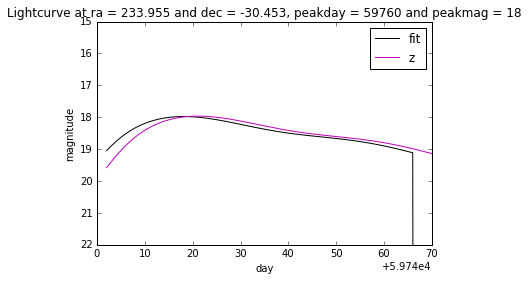

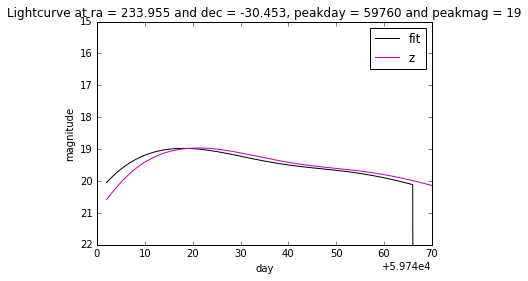

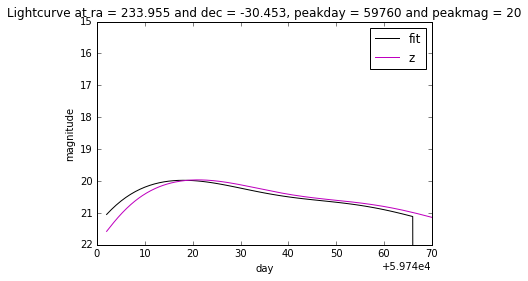

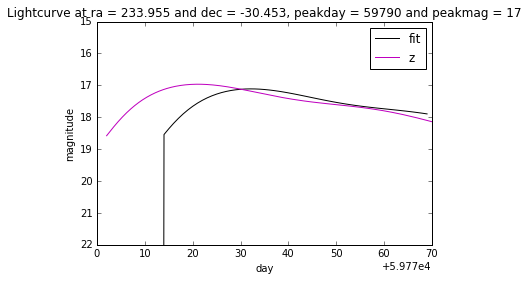

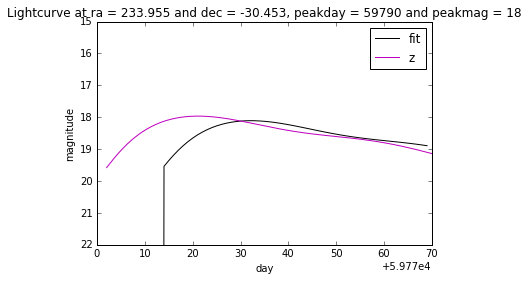

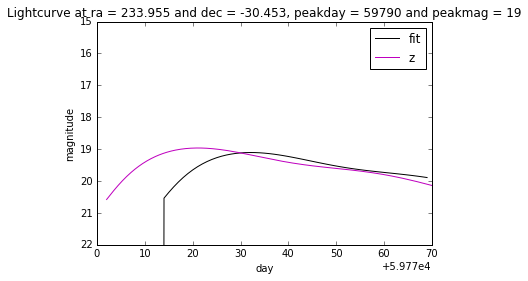

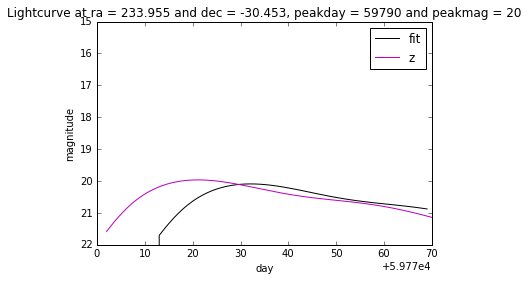

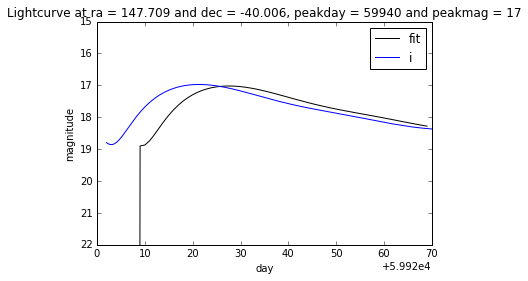

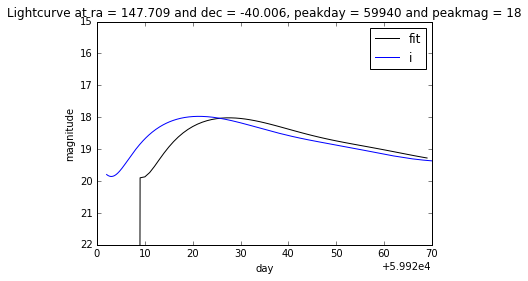

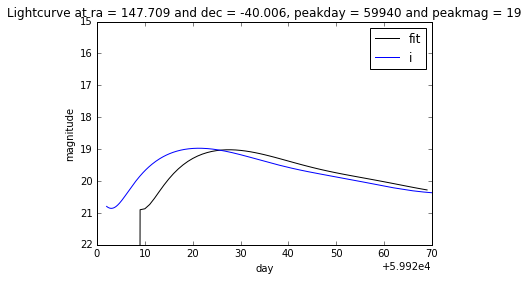

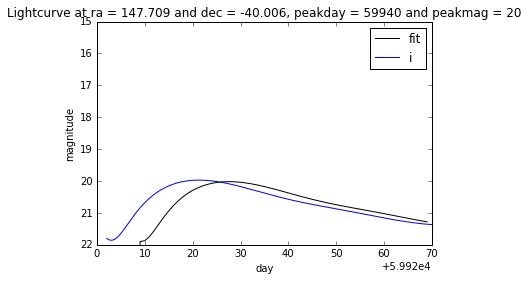

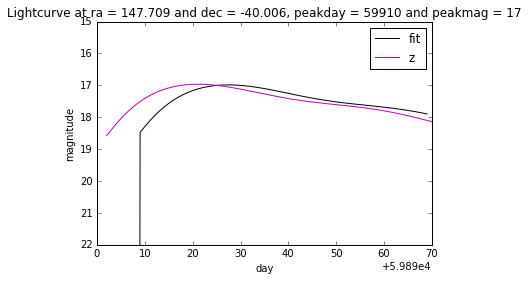

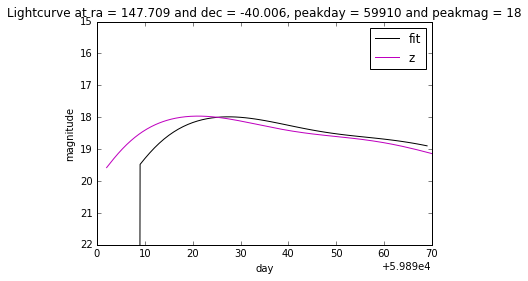

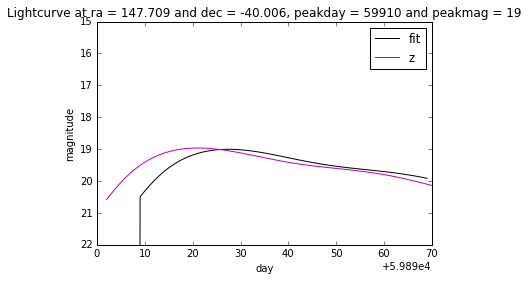

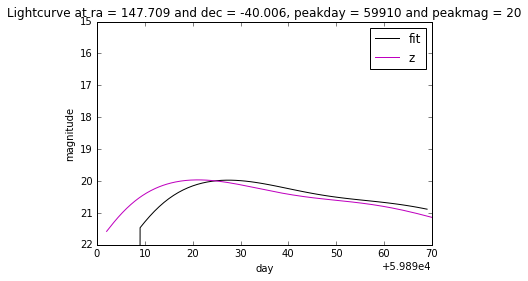

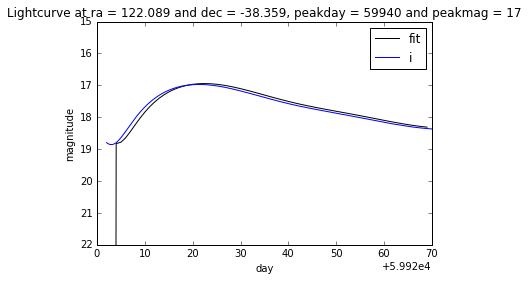

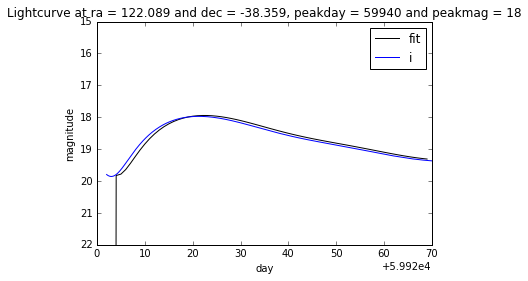

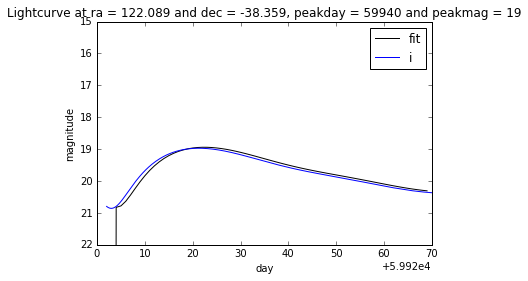

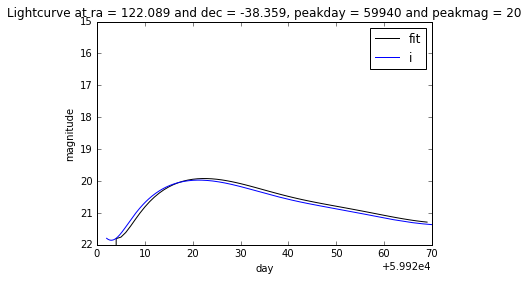

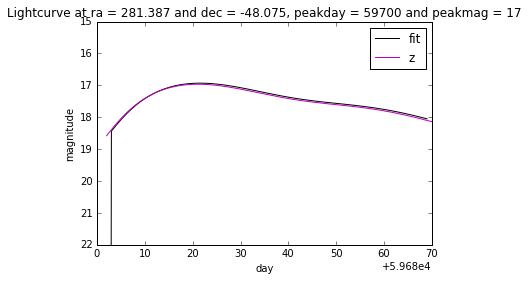

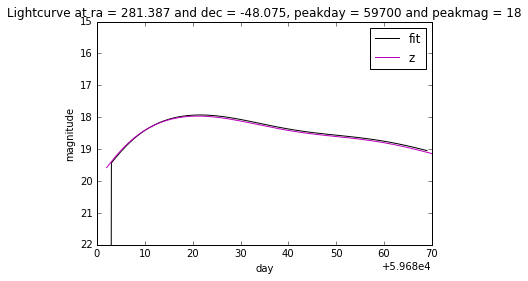

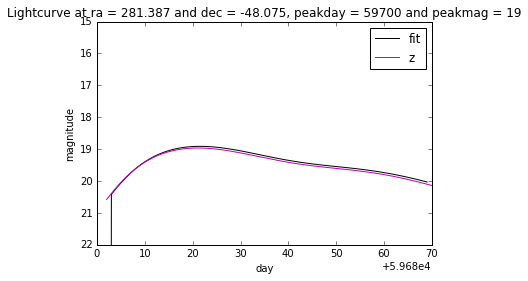

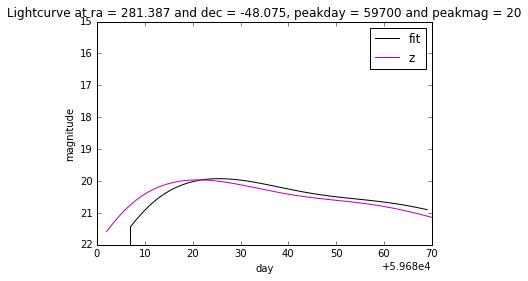

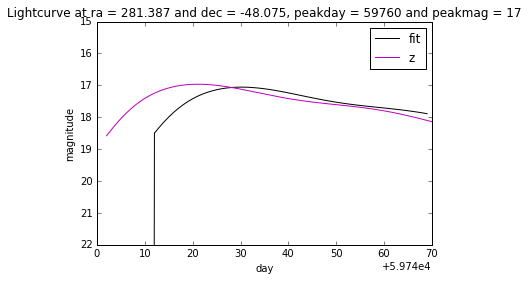

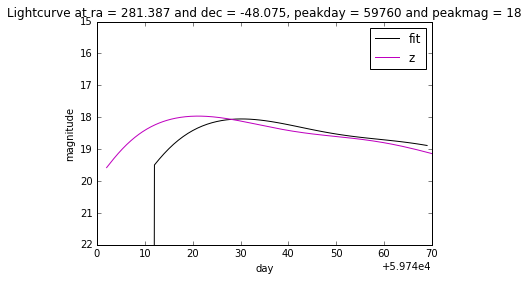

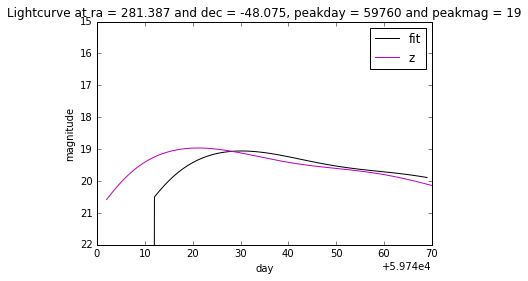

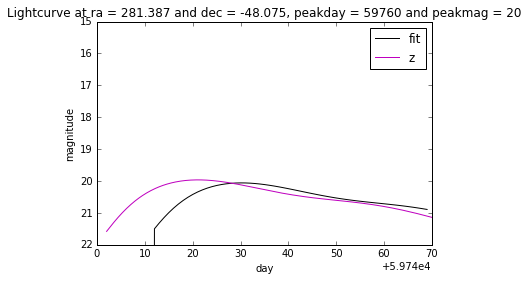

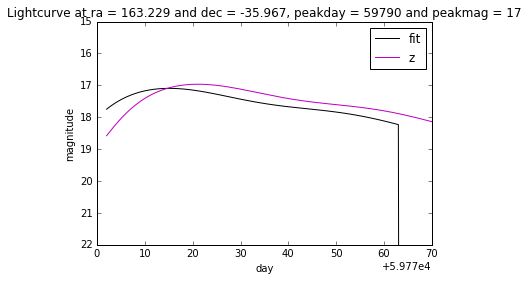

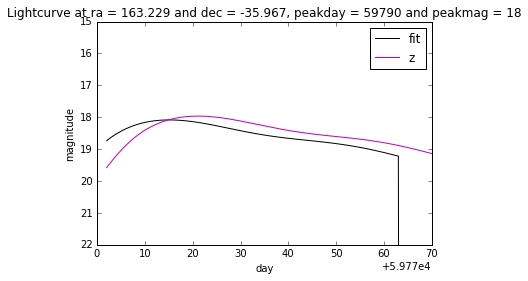

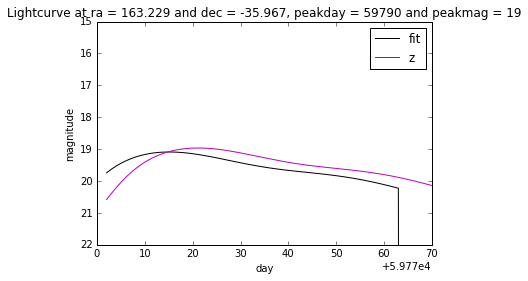

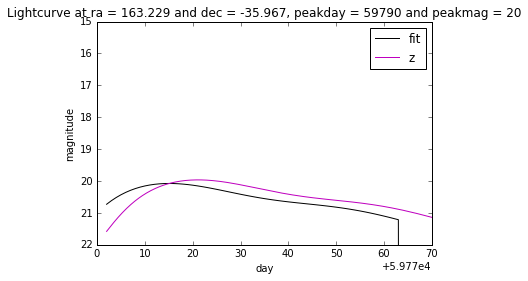

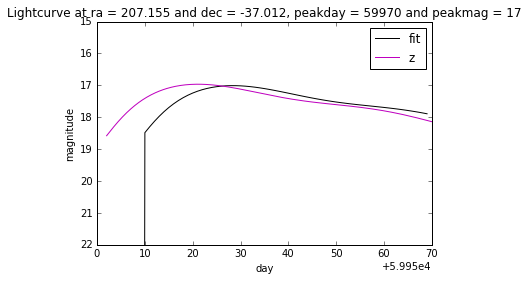

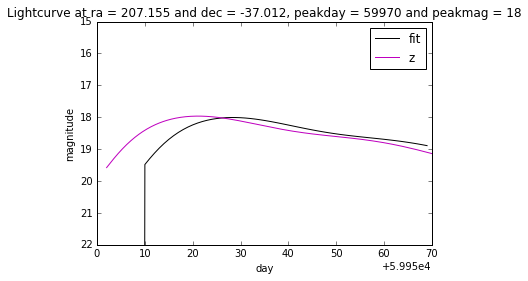

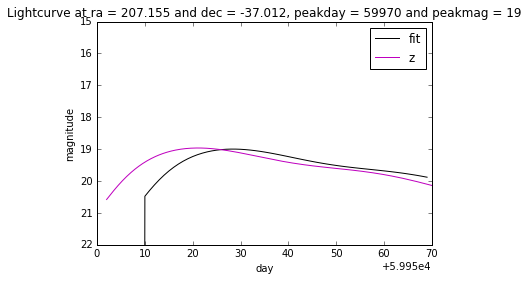

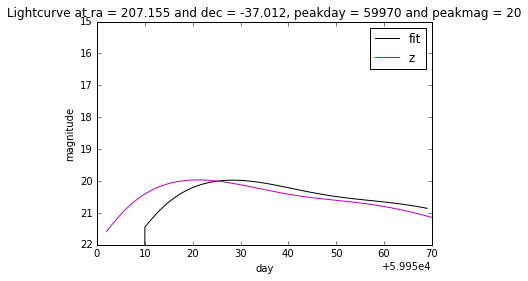

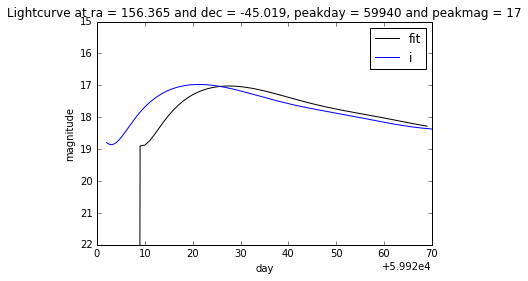

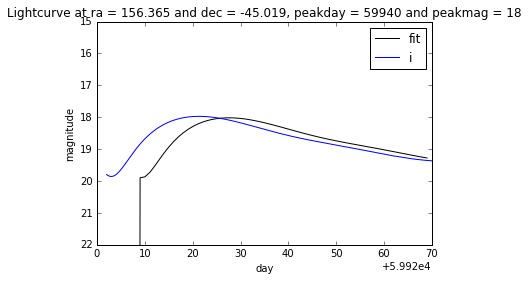

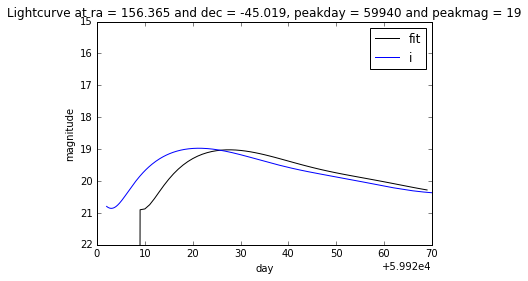

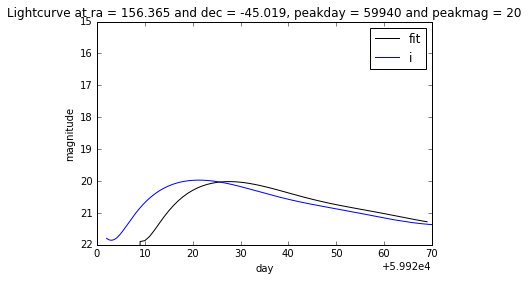

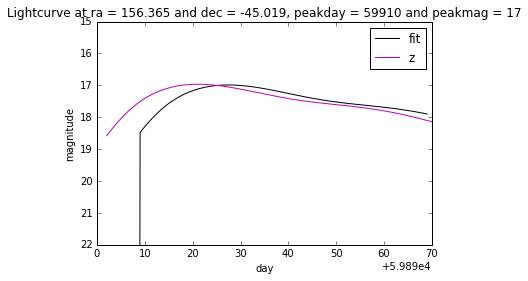

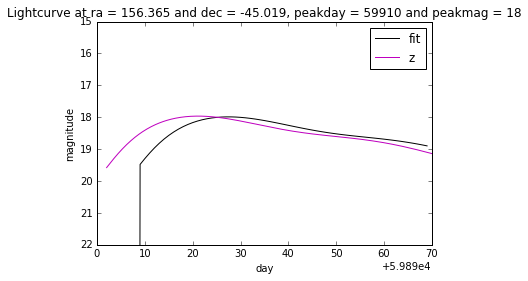

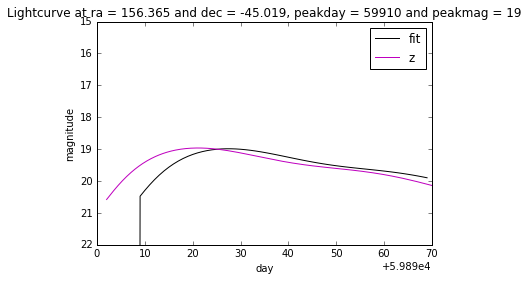

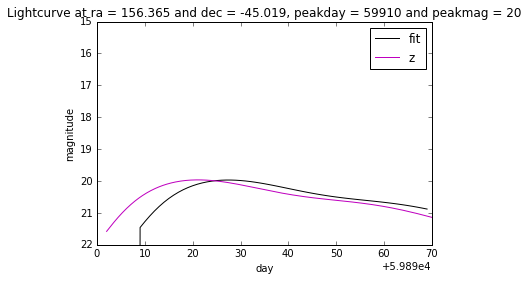

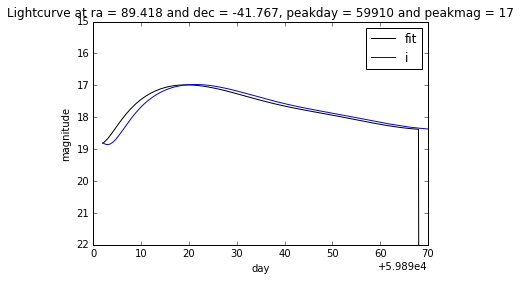

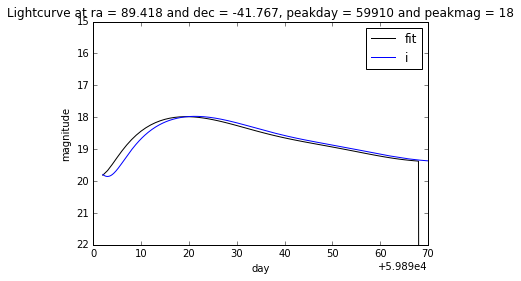

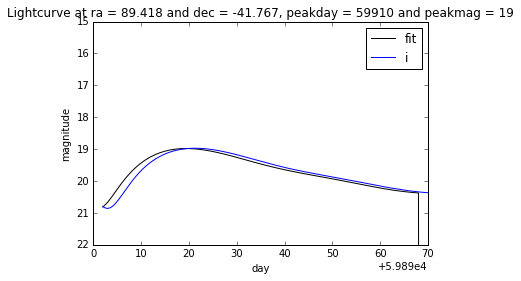

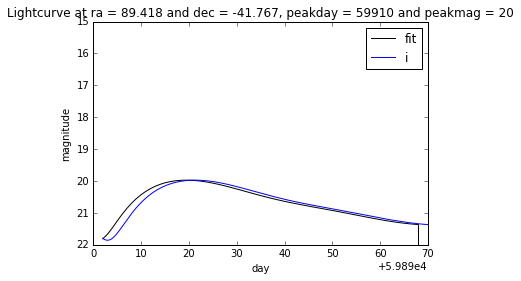

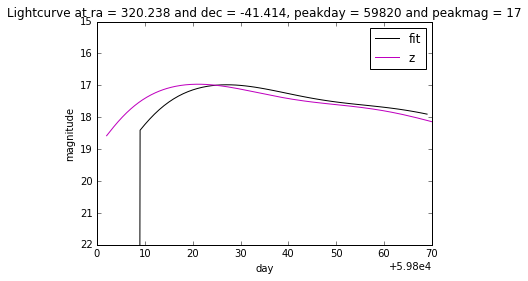

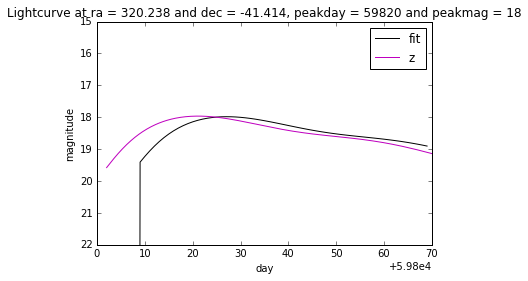

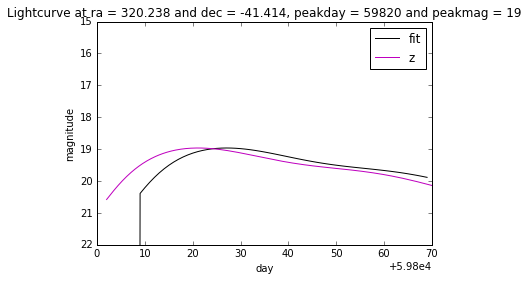

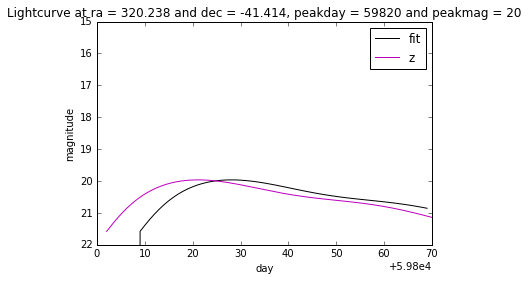

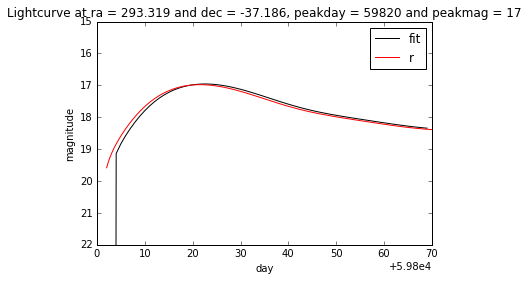

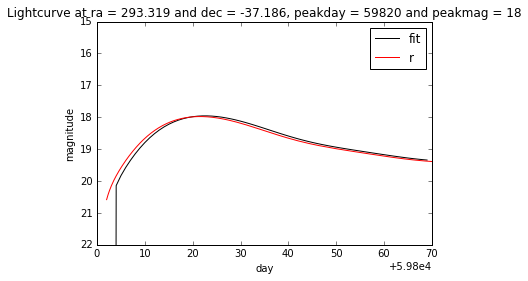

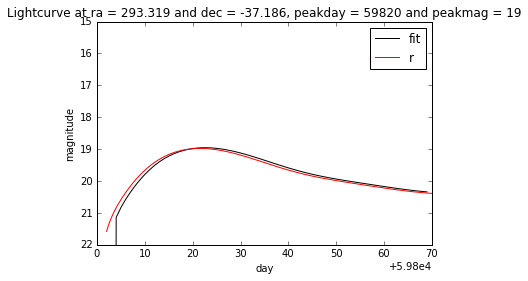

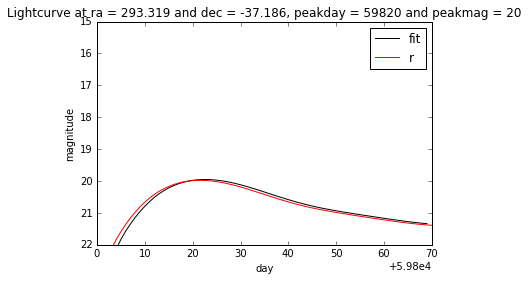

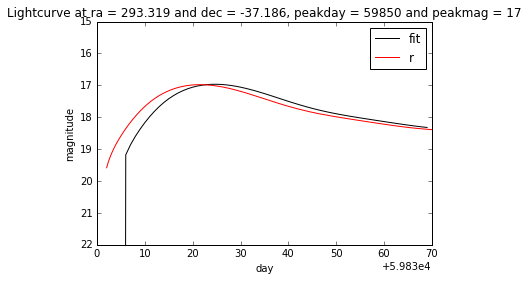

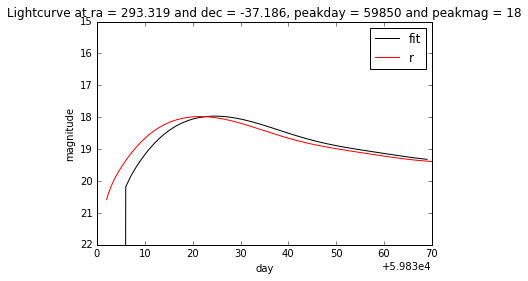

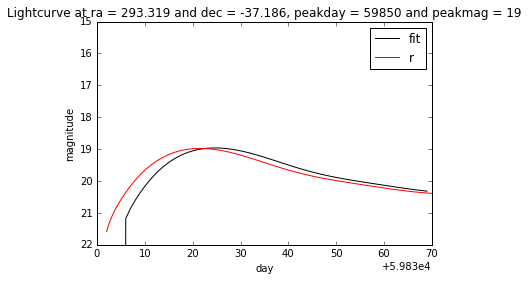

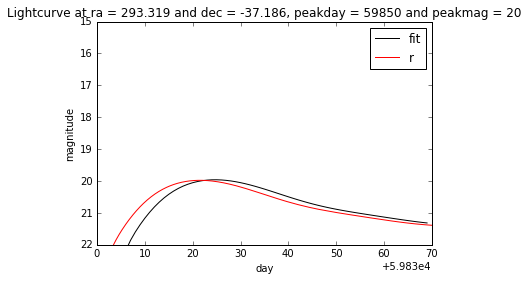

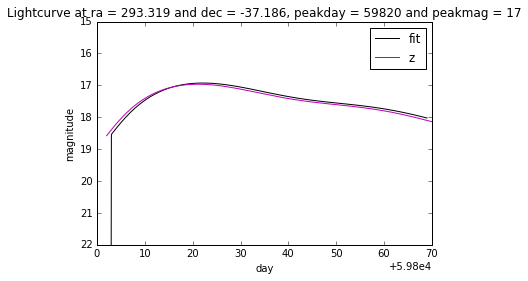

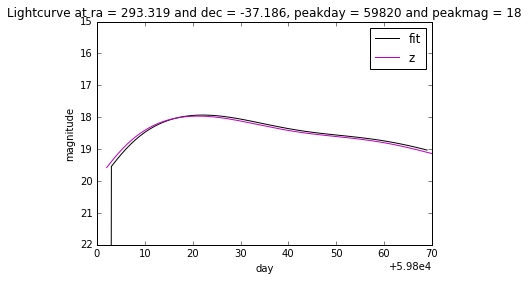

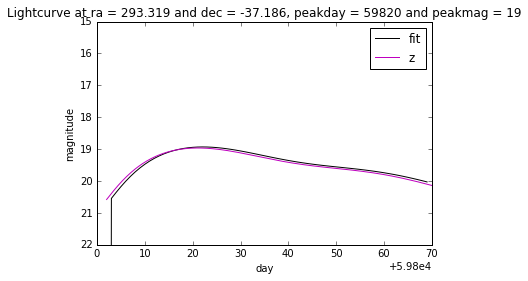

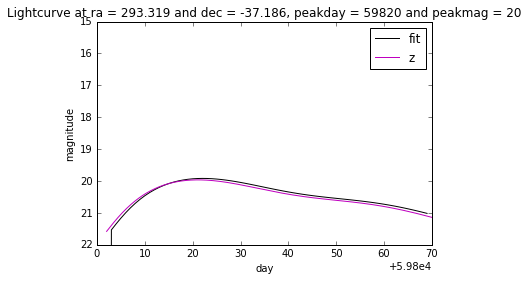

strong = 112
weak = 2804
unobserved = 1080
bad fit = 4


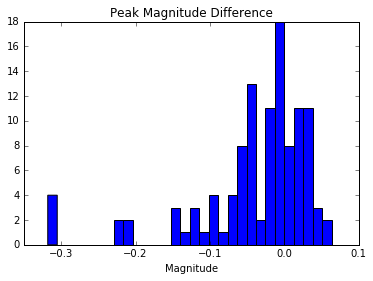

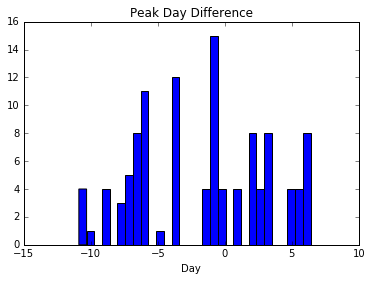

In [23]:
peak1 = 'peak magnitude difference'
peak2 = 'peak day difference'
percent_table = Table(names=('ra', 'dec', 'percent'), 
                                dtype=('float', 'float', 'float'))
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
peaktable = peak_brightness(template)
template = normalize_template(template)
peak_mag_difference = create_peak_difference_table(peak1)
peak_day_difference = create_peak_difference_table(peak2)
strong = 0
weak = 0
bad_fit = 0
unobserved = 0
for coord in range(len(bundle.metricValues)):
    opsim = survey[coord]
    ra = np.degrees(opsim['fieldRA'][0])
    dec = np.degrees(opsim['fieldDec'][0])
    for f in filterNames:
        for peakday in location_of_peak:
            for peakmag in height_of_peak:
                adjusted_template = adjust_peak(template, peakday, peakmag)
                new_opsim = adjust_opsim_table(opsim, adjusted_template)
                if len(new_opsim) == 0:
                    unobserved += 1
                else:
                    lightcurve = interpolate_light_curve(adjusted_template, new_opsim)
                    new_opsim = resample_light_curve(lightcurve, new_opsim)
                    new_opsim = calculate_error(new_opsim)
                    new_opsim = magnitude_distribution(new_opsim)
                    final_opsim = new_opsim.copy()
                    final_opsim = final_opsim[final_opsim['day'] <= (30 + adjusted_template['day'].min())]
                    fMatch = np.where(final_opsim['filter'] == f)
                    opsim_fmatch = final_opsim[fMatch]
                    opsim_fmatch['day'] = np.round(opsim_fmatch['day'])
                    if len(np.unique(opsim_fmatch['day'])) >= 3:
                        fMatch2 = np.where(new_opsim['filter'] == f)
                        opsim_fmatch2 = new_opsim[fMatch2]
                        fMatch3 = np.where(template['filter'] == f)
                        template_fmatch = template[fMatch3]
                        fMatch4 = np.where(adjusted_template['filter'] == f)
                        template_fmatch2 = adjusted_template[fMatch4]
                        xdata, popt = fit_curve(opsim_fmatch2, template_fmatch2, f)
                        peak_day_list = resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt)
                        peak_mag_list = resampled_peak_magnitude(ra, dec, f, template_fmatch2, xdata, popt)
                        create_curve(f, ra, dec, peakday, peakmag, 
                                opsim_fmatch2, template_fmatch2, xdata, popt)
                        if abs(peak_mag_list[3]) > 0.5 or abs(peak_day_list[3]) > 15:
                            #create_curve(f, ra, dec, peakday, peakmag, 
                            #    opsim_fmatch2, template_fmatch2, xdata, popt)
                            bad_fit += 1
                        else:
                            peak_mag_difference.add_row(peak_mag_list)
                            peak_day_difference.add_row(peak_day_list)
                            strong += 1
                    else:
                        weak += 1
                        
print('strong = %d' %(strong))
print('weak = %d' %(weak))
print('unobserved = %d' %(unobserved))
print('bad fit = %d' %(bad_fit))
plt.figure()
plt.hist(peak_mag_difference['peak magnitude difference'], bins = 30)
plt.title('Peak Magnitude Difference')
plt.xlabel('Magnitude')
plt.figure()
plt.hist(peak_day_difference['peak day difference'], bins = 30)
plt.title('Peak Day Difference')
plt.xlabel('Day')